In [1]:
import sklearn
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from tensorflow import keras
import tensorflow as tf
import pickle
import os
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_pickle("./train_data.pkl")
df_test = pd.read_pickle("./test_data.pkl")
df_train

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum,apk
571,2009,221048.0,77,1475.0,1.0,1,16,50
423,2009,149063.0,65,2850.0,1.0,1,16,147
804,2011,120669.0,69,4245.0,1.0,0,4,147
336,2012,128337.0,84,4950.0,1.0,0,16,147
351,2015,85858.0,80,7895.0,1.0,0,16,147
...,...,...,...,...,...,...,...,...
119,2007,130061.0,78,2949.0,1.0,1,16,263
294,2011,227017.0,84,1450.0,1.0,0,27,242
900,2013,84274.0,86,6450.0,1.0,1,16,147
460,2012,162000.0,86,4995.0,1.0,1,16,147


In [3]:
X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tf, X_valid, y_train_tf, y_valid = train_test_split(X_train, y_train)

Epoch 1/500
17/17 [==============================] - 0s 15ms/step - loss: 18438844.0000 - mae: 3655.5913 - mse: 18438844.0000 - val_loss: 17733694.0000 - val_mae: 3572.2107 - val_mse: 17733694.0000
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 18422276.0000 - mae: 3653.6216 - mse: 18422276.0000 - val_loss: 17708864.0000 - val_mae: 3569.2576 - val_mse: 17708864.0000
Epoch 3/500
17/17 [==============================] - 0s 4ms/step - loss: 18384282.0000 - mae: 3649.2720 - mse: 18384282.0000 - val_loss: 17656280.0000 - val_mae: 3563.0947 - val_mse: 17656280.0000
Epoch 4/500
17/17 [==============================] - 0s 4ms/step - loss: 18308216.0000 - mae: 3640.5068 - mse: 18308216.0000 - val_loss: 17553324.0000 - val_mae: 3551.2019 - val_mse: 17553324.0000
Epoch 5/500
17/17 [==============================] - 0s 4ms/step - loss: 18163962.0000 - mae: 3624.4062 - mse: 18163962.0000 - val_loss: 17370158.0000 - val_mae: 3530.2290 - val_mse: 17370158.0000
Epoch 6/500
17

(0.0, 61.0)

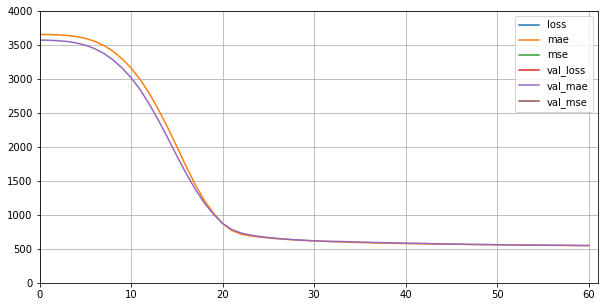

In [4]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train.shape[1:]),
#     keras.layers.Dense(200, activation="relu"),
#     keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(
    loss="mean_squared_error", 
    optimizer=optimizer, 
    metrics=['mae', 'mse']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

history = model.fit(
    X_train_tf, 
    y_train_tf.values, 
    batch_size=32, 
    epochs=500, 
    validation_data=(X_valid, y_valid.values),
    verbose=1,
    callbacks=[callback]
)

mse_test = model.evaluate(X_test, y_test.values)

pd.DataFrame(history.history).plot(figsize=(10, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 4000) 
plt.gca().set_xlim(0, len(history.history['loss'])) 

In [5]:
model_version = "0001"
model_name = "TFAuto"
model_path = os.path.join(model_name) 
model.save(model_path)
scaler_path = os.path.join(model_name, 'TFScaler.pkl') 
joblib.dump(scaler, scaler_path) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: TFAuto\assets


['TFAuto\\TFScaler.pkl']